# TS-LSTM Model

Reference Article- https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf

Much Better Documentation- https://www.tensorflow.org/tutorials/generative/autoencoder

Phenomenal Interactive Tutorial- https://anomagram.fastforwardlabs.com/#/

- [Requirements.txt](requirements.txt) (in same dir) lists all of the dependencies, need replicate with a new conda env
  - conda create --name `<new_env_name>` --file requirement.txt

- Originally was feeding in data like [1284, 20, 1] -- assuming [NumberSamples, Timesteps, FeaturesAtTimesteps], this however has led to some downstream errors in evaluating the model against the acutal market data, so will try to include previous 20 day values as the number of features at a SINGLE timestep = [1284, 1, 20]

- Training the model for +100 Epochs doesn't really seem to add any value to predictive accuracy, keep number of runs over data to min for testing

- Time series is built on top of Gini Coefficients, not on direct volume values -- compare against fourier version of Transformed GCs
- Autoencoders look to reproduce a given $x$ that is pulled from some numeric distribution (in our case daily gini coefficients for stock market volume values)

In [1]:
import os 
import random
import numpy as np 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

# from StockData import * 
from StockDataToGinis import * 

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


In [ ]:
# Generate Randomized Sequences + Historical Set -- DEPRECATED

stock_data = "../Data Quality (Stocks)/Stocks_Cleaned.csv"
WINDOW_LEN = 20 #number of days to pull data for, test set size, reshape in MinMaxScaler

X_train, X_test = getAutoencoderGiniData(data_path=stock_data #returns arbitrary number of samples as specified in read data file, var="n_samples"
                                          , n_days=WINDOW_LEN, column="volume", n_samples=10_000)

X_total, y_total = getHistoricalData(data_path=stock_data, n_days=WINDOW_LEN, column="volume", ticker="AAPL", normalize=False)

In [2]:
# Read in Saved TSVs of Array Data & Reshape

X_train = np.loadtxt("autoencoder_data/train.tsv")
X_test = np.loadtxt("autoencoder_data/test.tsv")

# Reshape to fit LSTM Data Schema
X_train = X_train.reshape(9980, 1, 20)
X_test = X_test.reshape(20, 1, 20)

In [3]:
# Normalization -- MinMax Transformation (saving scaler for inverse transform)
from sklearn.preprocessing import MinMaxScaler

# Instantiate Scalers & Fit to Train Set
WINDOW_LEN = 20 

X_mms = MinMaxScaler()
X_mms.fit(X_train[:, 0, :])

X_train = X_mms.transform(X_train[:, 0, :])
X_train = X_train.reshape((len(X_train), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

X_test = X_mms.transform(X_test[:, 0, :])
X_test = X_test.reshape((len(X_test), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

# X_total = X_mms.transform(X_total[:, 0, :]) #historical set not really needed, just stripping sequences (saved serve as baseline for models to eval against)
# X_total = X_total.reshape((len(X_total), 1, WINDOW_LEN))


# Convert ndarrays to tf tensors -- convert either here or in Model Call
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test  = tf.convert_to_tensor(X_test, dtype=tf.float32)
# X_total = tf.convert_to_tensor(X_total, dtype=tf.float32)



2022-04-20 10:18:21.700142: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Save Randomly Generated Arrays for Model Tests

Used to save a set of generated data, can read in saved arrays with `loadtxt` cell above

In [ ]:
print(X_test.shape)
xt = X_test.reshape(20, 20)
print(xt.shape)

In [23]:
xt.shape #(20, 20)
xt.reshape(20, 1, 20).shape #reshape on entry

(20, 1, 20)

In [20]:
# Write out Train & Test Sets for Eval later (generated randomly, need same data to compare models)

X_train.shape

train = X_train.reshape(9980, 20)
test = X_test.reshape(20, 20)

np.savetxt('autoencoder_data/train.tsv', train, delimiter='    ')
np.savetxt('autoencoder_data/test.tsv', test, delimiter='    ')

## Define TS-LSTM Architecture

LSTM Layers all the way down? Or should we incorporate a few dense ones? (need roughly same architecture as Linear Autoencoder)

In [4]:
# Autoencoder Architecture 
class TS_LSTM(Model):
  def __init__(self, latent_large, latent_small):
    super(TS_LSTM, self).__init__()
    self.latent_large = latent_large
    self.latent_small = latent_small

    self.encoder = tf.keras.Sequential([
      layers.Dense(20, name="input"), #input layer
      layers.LSTM(latent_large, activation='relu', name="lstm-1", return_sequences=True, unroll=True), #can convert back into dense layers -- need experiment 
      layers.LSTM(latent_small, activation='relu', name="lstm-2", return_sequences=True, unroll=True)
                                        ])
    self.decoder = tf.keras.Sequential([
      layers.LSTM(latent_small, activation='relu', return_sequences=True, name="lstm-3", unroll=True),
      layers.LSTM(latent_large, activation='relu', return_sequences=True, name="lstm-4", unroll=True),
      layers.Dense(20, activation='relu') #output effectively (20 value, reconstructed sequence), activation typically used here is sigmoid
                                        ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




# Root Mean Squared Loss -- For Training
def rmse_loss(target_y, predicted_y):
  return tf.matrix_square_root(tf.reduce_mean(tf.square(target_y - predicted_y))) 
  # return tf.reduce_mean(tf.square(target_y - predicted_y)) #original MSE loss function


# Update Model params for 1 Epoch of Training -- to be used in training cycles per epoch
def train(model, x, learning_rate=1e-2):
  with tf.GradientTape() as t:
    current_loss = rmse_loss(x, model(x)) #autoencoder loss is determined by reconstruction of the original sequence
  
  # Gradient Update
  dw = t.gradient(current_loss, model.weights)
  model.weights.assign_sub(learning_rate * dw)
  return train_loss, val_loss
  
# IDEALLY GET ABOVE FUNCTION TO RETURN VALS LIKE `MODEL.fit().history`





# Instantiate Autoencoder
set_seeds(seed=42)
autoencoder = TS_LSTM(latent_large=50, latent_small=20)
optimizer = tf.keras.optimizers.Adam(lr=1e-2)
autoencoder.compile(optimizer=optimizer, loss='rmse')
autoencoder.build(input_shape=X_train.shape)
autoencoder.summary()

/Users/ckg-files/miniconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "ts_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (9980, 1, 20)             20300     
                                                                 
 sequential_1 (Sequential)   (9980, 1, 20)             18500     
                                                                 
Total params: 38,800
Trainable params: 38,800
Non-trainable params: 0
_________________________________________________________________


In [ ]:
17060 / (514 * 4)

In [29]:
# Training - Scaled Data


# Old `.fit` training
n_epochs = 10
batch_size = 10 #10 seems to be a good size for this dataset (accuracy & n of gradient updates)
# history = autoencoder.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.07).history #train on Random Sampled Data


# New Chad Training
n_epochs = 10
batch_size = 10 #10 seems to be a good size for this dataset (accuracy & n of gradient updates)
lr = 1e-2 
set_seeds() #reproducibility!


# Custom Training Loop -- calls `train` in Model Definition Cell to update model params
def training_cycle():
    history = dict() #save Train, Val Losses & Test Accuracies

    for epoch in n_epochs:
        train_loss, val_loss = train(autoencoder, X_train, learning_rate=lr)

        test_error, avg_test_error = reconstruction_accuracy(X_test, autoencoder, show=False) #func is defined in cells below, move it up later

    return history


Train on 9281 samples, validate on 699 samples
Epoch 1/10
9281/9281 [==============================] - 11s 1ms/sample - loss: 0.1333 - val_loss: 0.0859
Epoch 2/10
9281/9281 [==============================] - 8s 853us/sample - loss: 0.0856 - val_loss: 0.0843
Epoch 3/10
9281/9281 [==============================] - 8s 883us/sample - loss: 0.0853 - val_loss: 0.0844
Epoch 4/10
9281/9281 [==============================] - 8s 909us/sample - loss: 0.0853 - val_loss: 0.0844
Epoch 5/10
9281/9281 [==============================] - 9s 966us/sample - loss: 0.0851 - val_loss: 0.0850
Epoch 6/10
9281/9281 [==============================] - 9s 981us/sample - loss: 0.0792 - val_loss: 0.0787
Epoch 7/10
9281/9281 [==============================] - 9s 934us/sample - loss: 0.0765 - val_loss: 0.0777
Epoch 8/10
9281/9281 [==============================] - 9s 1ms/sample - loss: 0.0764 - val_loss: 0.0763
Epoch 9/10
9281/9281 [==============================] - 8s 902us/sample - loss: 0.0760 - val_loss: 0.0777
Ep

In [108]:
history

{'loss': [0.1333350485288889,
  0.08563803282775392,
  0.08531158258914691,
  0.08532957962753572,
  0.08505103256091413,
  0.07920763541810562,
  0.07646642848022435,
  0.07639259593949635,
  0.07599612333136584,
  0.07177754571203168],
 'val_loss': [0.08590252082448491,
  0.08434230782017005,
  0.08444160628045919,
  0.08440981321409878,
  0.08497998668400515,
  0.07868366817462769,
  0.07765204698188452,
  0.07632475300493499,
  0.07766558773527842,
  0.07425563130128025]}

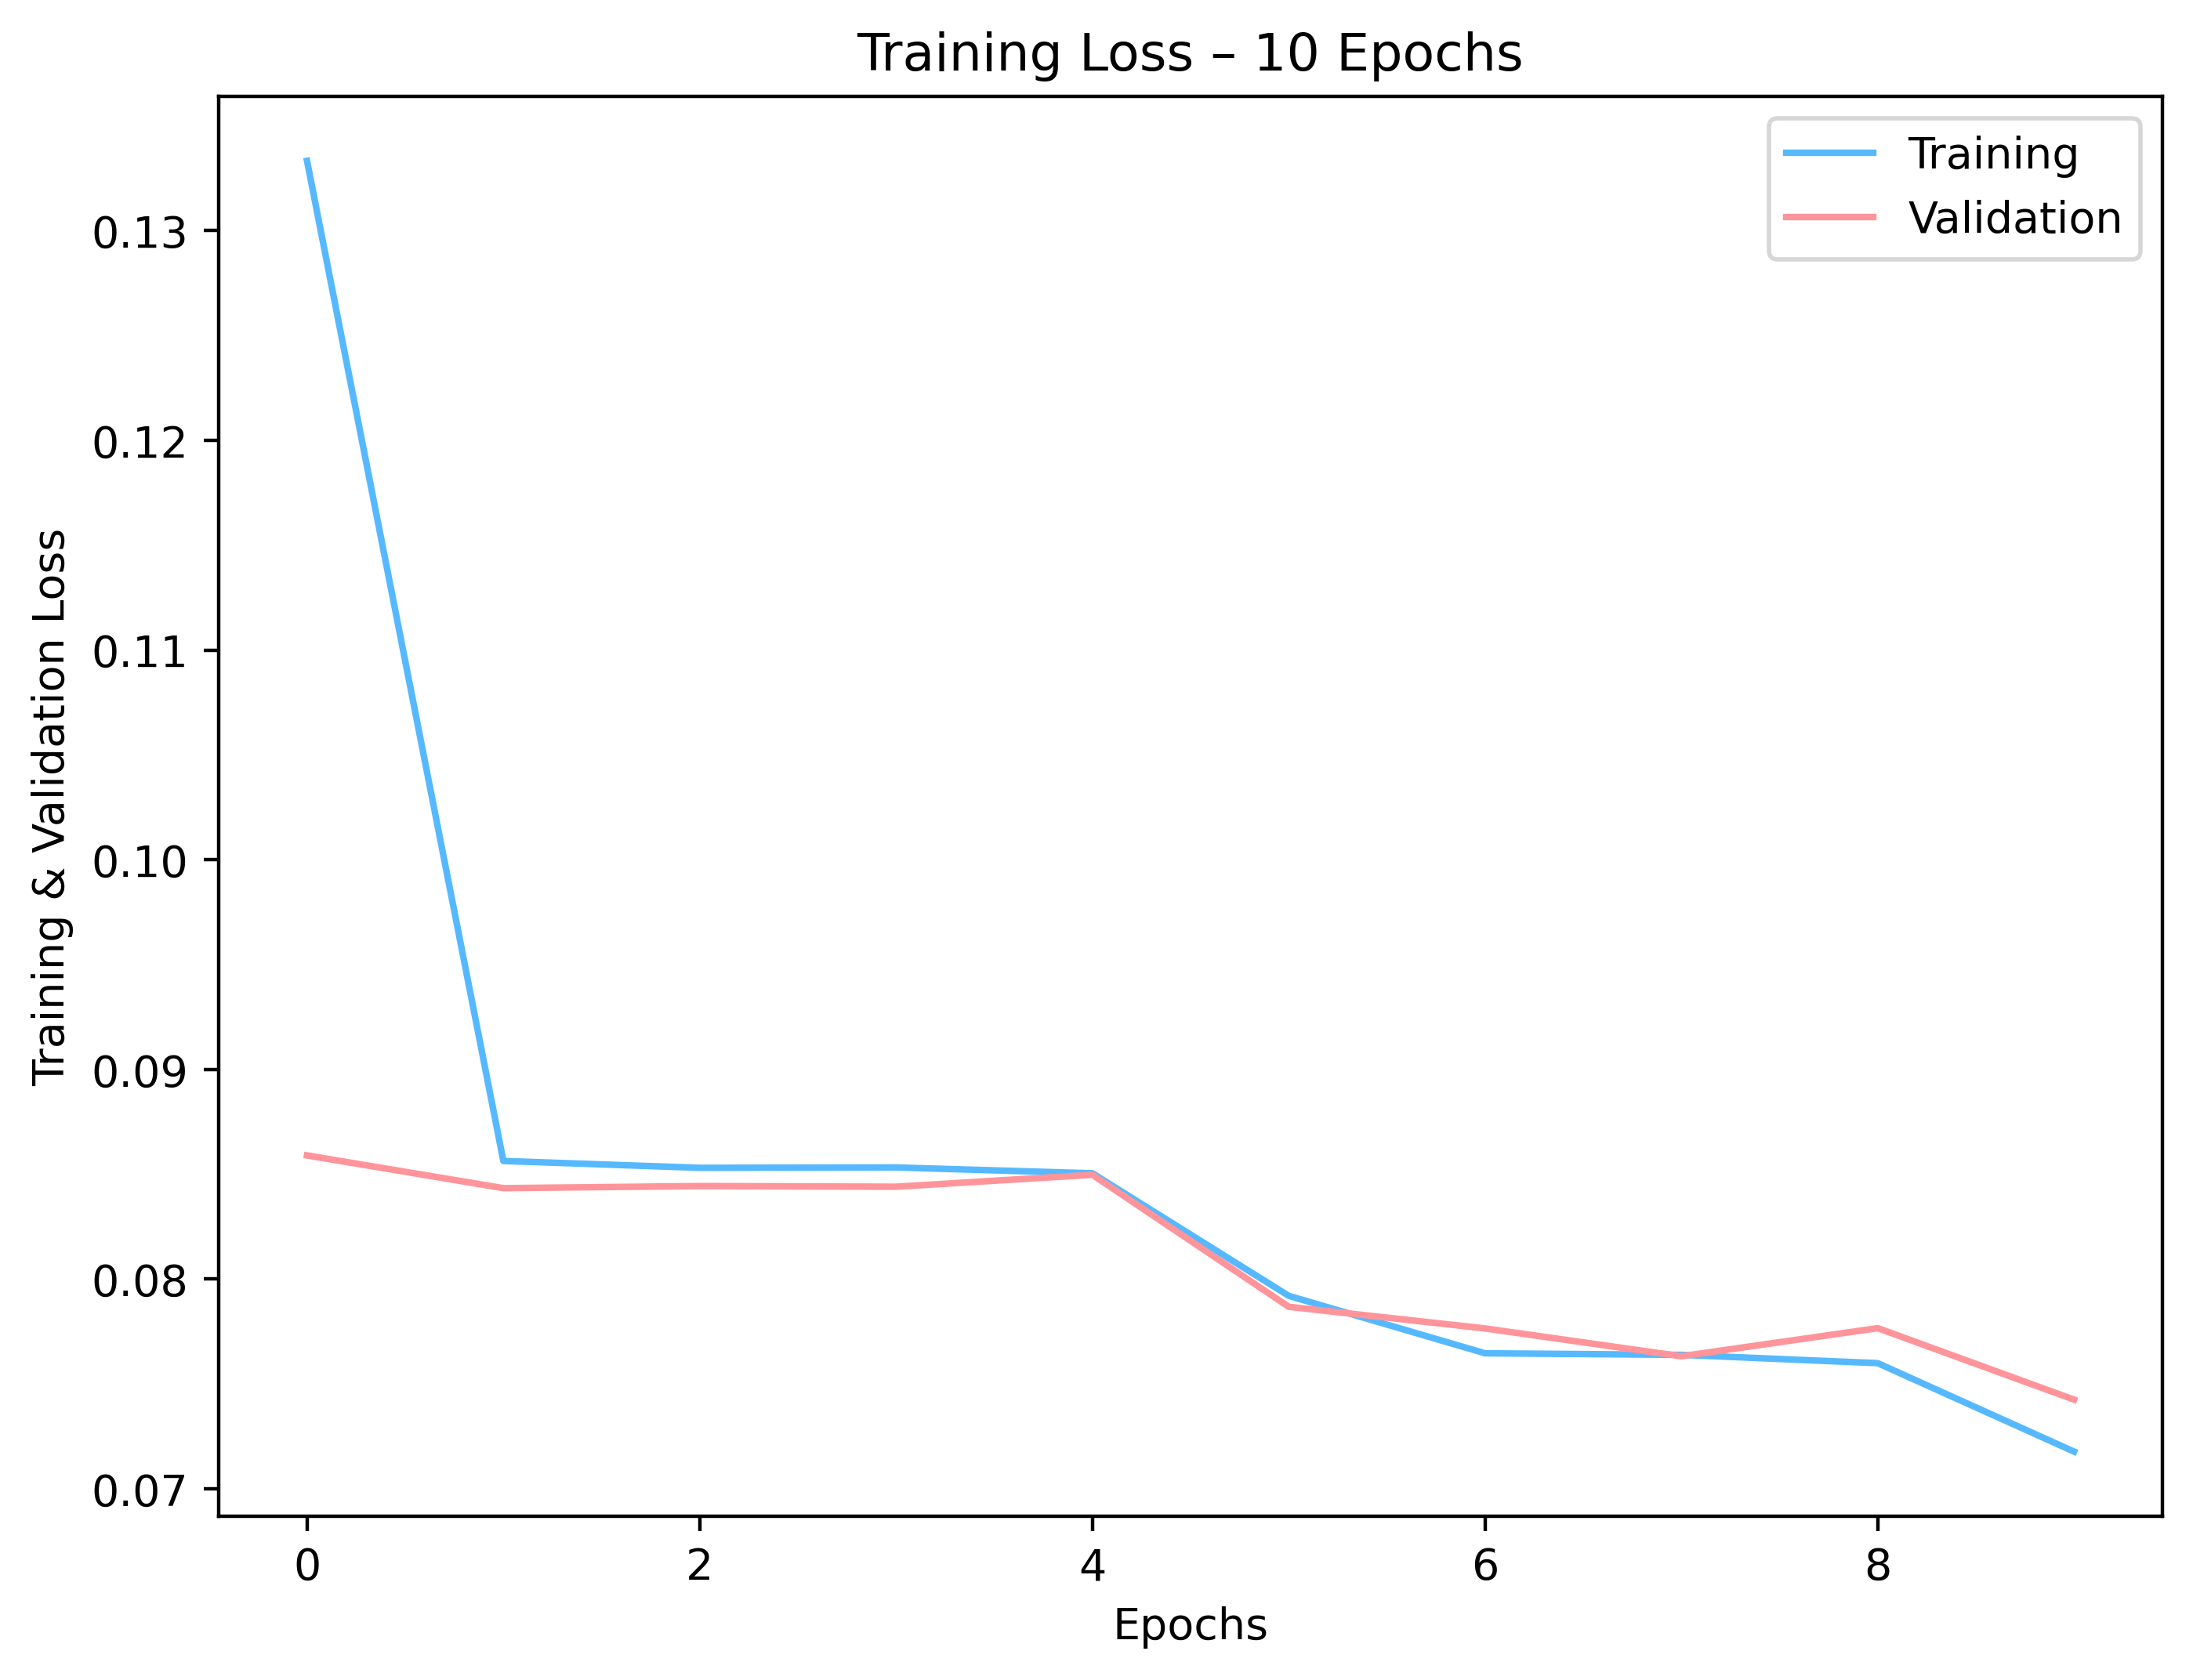

In [30]:
# Plot History from Model Training -- Accuracy
import matplotlib.pyplot as plt 

plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(8, 6), dpi=400)
plt.title(f"Training Loss – {n_epochs} Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training, Validation & Test Loss per Epoch")

plt.plot(range(n_epochs), history["train_loss"], color="#56B9FF", label="Training")
plt.plot(range(n_epochs), history["val_loss"],   color="#ABE9B3", label="Validation")
plt.plot(range(n_epochs), history["test_loss"],  color="#FF949A", label="Test")
plt.legend(loc="best")



In [65]:
# Compute Errors for Aggregate Reproductions -- How well does Trained Autoencoder do on all Test Data?

# Get Preds for Test Set
h = autoencoder.encoder(X_test).numpy()
decoded = autoencoder.decoder(h).numpy()

# Get Error Statistics
mse = (np.sum(X_test - decoded)**2)/len(decoded)
mse = float(mse)/len(decoded)
rmse = np.sqrt(mse)
avg_rmse = np.sqrt(mse)/20

print(f"      RMSE on Entire Set: {100 * rmse:.2f}%\nAverage RMSE per Example: {100 * avg_rmse:.2f}%") 
       #RMSE puts error in terms of original data domain (RMSE un-does squaring from MSE calculation, whilst still preserving the error & penalizing larger errors)

      RMSE on Entire Set: 58.32%
Average RMSE per Example: 2.92%


In [102]:
# Test Reconstruction Accuracy Func -- basically wraps above cell for use in training loop

def reconstruction_accuracy(testset, model, show=True):
    # Get Preds for Real Historical Data
    h = model.encoder(testset).numpy()
    decoded = model.decoder(h).numpy()

    # Get Error Statistics
    mse = (np.sum(testset-decoded)**2)/len(decoded)
    mse = float(mse)
    rmse = np.sqrt(mse)
    
    avg_rmse = rmse/len(decoded)

    if show:
        print(f"Total RMSE for Entire Set: {100 * rmse:.2f}%\n  Average RMSE per Example: {100 * avg_rmse:.2f}%")
    return rmse, avg_rmse

In [103]:
reconstruction_accuracy(X_test, autoencoder)

Total RMSE for Entire Set: 260.83%
  Average RMSE per Example: 13.04%


(2.608271567898968, 13.041357839494841)

In [ ]:
# View Difference Between Recreated & Original Sequences (Single Example)

# Get Preds
encoded_data = autoencoder.encoder(X_test).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

# Values to Plot
index_in_test = 1
x_pred_plot = decoded_data[index_in_test]
x_test_plot = X_test[index_in_test].numpy().reshape(-1)


# Inverse Transform -- need reshape twice, MinMaxScaler expects mulit-dim array & Plotter needs 1d array
# x_pred_plot = X_mms.inverse_transform(x_pred_plot.reshape(1, 20)).reshape(-1)
x_pred_plot = x_pred_plot.reshape(1, 20).reshape(-1)

# x_test_plot = X_mms.inverse_transform(x_test_plot.reshape(1, 20)).reshape(-1) 
x_test_plot = x_test_plot.reshape(1, 20).reshape(-1)


# Get Error Statistics
mse = (np.sum(x_test_plot - x_pred_plot)**2)/len(x_test_plot)
rmse = float(np.sqrt(mse))


# Plot Difference Curves
plt.plot(x_test_plot, "#56B9FF")
plt.plot(x_pred_plot, '#ABE9B3')
plt.fill_between(np.arange(20), x_pred_plot, x_test_plot, color='#F28FAD', alpha=0.5)
plt.legend(labels=["Original", "Reconstructed", "Error"])

plt.title(f"{index_in_test} - Recreation of Original Gini Signal - RMSE: {100 * rmse:.2f}%")
plt.xlabel("Trading Days")
plt.ylabel("Volume")
plt.show()

In [105]:
# Haven't moved over to Import func -- evaluate multiple instances against each other

def plot_reconstruction(model, test_set, indicies):
    # Get Preds
    encoded_data = model.encoder(test_set).numpy()
    decoded_data = model.decoder(encoded_data).numpy()
    
    # Generate Plots
    print("Recreations of Original Signals")
    for i in indicies: #change this for different curves
        x_pred_plot = decoded_data[i]
        x_test_plot = X_test[i].numpy().reshape(-1)

        # Inverse Transform -- need reshape twice, MinMaxScaler expects mulit-dim array & Plotter needs 1d array
        # x_pred_plot = X_mms.inverse_transform(x_pred_plot.reshape(1, 20)).reshape(-1)
        x_pred_plot = x_pred_plot.reshape(1, 20).reshape(-1)

        # x_test_plot = X_mms.inverse_transform(x_test_plot.reshape(1, 20)).reshape(-1) 
        x_test_plot = x_test_plot.reshape(1, 20).reshape(-1)

        # Get Error Statistics
        mse = (np.sum(x_test_plot - x_pred_plot)**2)/len(x_test_plot)
        rmse = float(np.sqrt(mse))

        # Plot Difference Curves
        plt.plot(x_test_plot, "#56B9FF")
        plt.plot(x_pred_plot, '#ABE9B3')
        plt.fill_between(np.arange(20), x_pred_plot, x_test_plot, color='#F28FAD', alpha=0.5)
        plt.legend(labels=["Original", "Reconstructed", "Error"])

        plt.title(f"Index: {i} - RMSE: {100 * rmse:.2f}%")
        plt.xlabel("Trading Days")
        plt.ylabel("Volume")
        plt.show()

    return

Recreations of Original Signals


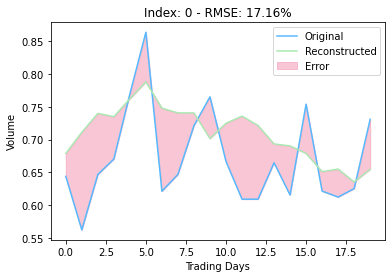

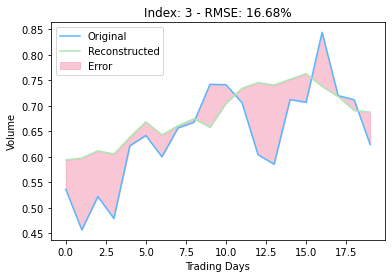

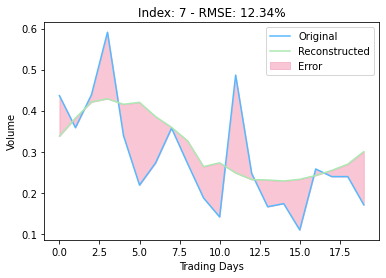

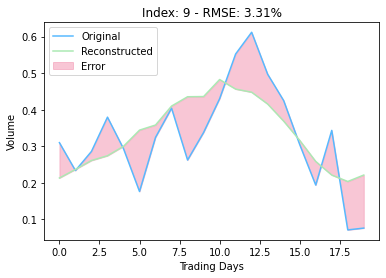

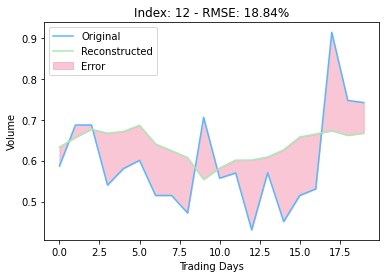

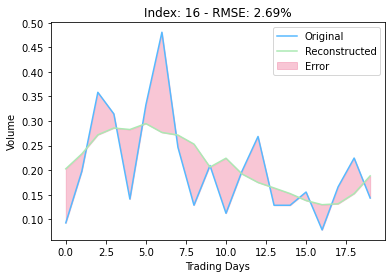

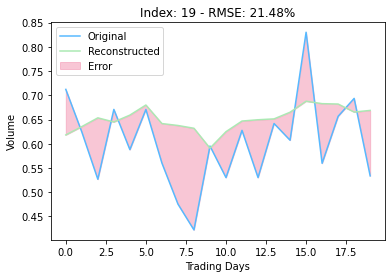

In [99]:
# View Difference Between Sequence (Multi Examples)
# plot_reconstruction(autoencoder, X_test, range(0, 20)) #plot all 
plot_reconstruction(autoencoder, X_test, [0, 3, 7, 9, 12, 16, 19]) #plot specified subset



#### Deprecated Code -- Previous Method

In [ ]:
# Use TS-LSTM to RePredict the Whole Market Data -- Scalar Output
import matplotlib.pyplot as plt
import numpy as np

# Use model to Predict full sequence
y_pred = model.predict(X_total) #returns np.ndarray


# Reshape Arrays
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[2]) #drop 2nd Dimension, no values
y_pred = y_pred.reshape(-1, 1)
yt = y_total.numpy()
yt = yt.reshape(-1, 1)


# Calculate Error -- Showcase in Plot
mse = (np.sum(y_total - y_pred)**2)/len(y_pred)
mse = float(mse)

rmse = np.sqrt(mse)
rmse = float(rmse)

mae = float((np.sum(np.absolute(y_total - y_pred)))/len(y_pred))


# Apply Inverse Transforms (on preds & actual array)
y_pred = y_mms.inverse_transform(y_pred) #both are scaled?
y_pred = y_pred.astype(int)

yt = y_mms.inverse_transform(yt) #both are scaled?
yt = yt.astype(int)


# Plot Market Data Vs. Predicted Movements
plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(12, 8), dpi=400)
plt.title(f"AAPL - Recreation of Original Signal\nErrors– MSE: {100 * mse:.2f}% | RMSE: {100 * rmse:.2f}% | MAE: {100 * mae:.2f}%")
plt.xlabel("Trading Days")
plt.ylabel("Volume")

# plt.plot(range(X_total.shape[0]), y_total, color="#56B9FF", label="Original") #first variation, can del
plt.plot(range(X_total.shape[0]), yt, color="#56B9FF", label="Original")
plt.plot(range(X_total.shape[0]), y_pred,  color="#FF949A", label="TS-LSTM")
plt.legend(loc="best")

In [24]:
X_total.numpy().reshape(1284, 20)

array([[0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       ...,
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045]], dtype=float32)

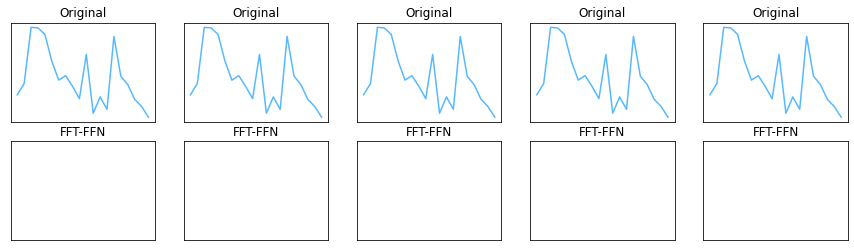

In [96]:
y_pred = model.predict(X_total) #returns np.ndarray

n = 5
plt.figure(figsize=(15, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.plot(X_total.numpy().reshape(1284, 20)[i], color="#56B9FF")
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(y_pred[i],  color="#FF949A")
    plt.title("FFT-FFN")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Plot Loss Distribution - Preds against Actuals
import seaborn as sns 

test_pred = model.predict(X_test)
print(test_pred.shape)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
print(test_pred.shape, y_test.shape)

pred_scores = np.mean(np.abs(test_pred-y_test), axis=1) #calculate difference

# Plotting
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution - Average Absolute Difference', fontsize=16)
sns.distplot(pred_scores, bins=20, kde=True, color='#9994FF');
plt.xlim([0.0,.5])

## Test Misc Functions

In [4]:
# TESTING CELL -- Nonessential
import pandas as pd 

df = pd.read_csv("../Data Quality (Stocks)/Stocks_Cleaned.csv")
df[["date", "volume", "Name"]].set_index("date").loc["2013-02-08"] #example of filtering by datetime index

seq = df[["date", "volume", "Name"]].set_index("date")
seq = df[["date", "volume", "Name"]]
dates_array = df["date"].unique()

In [ ]:
# Save & Load w HDF5 Format -- tossing an error currently, H5 package is too new?
model.save(r'./models/TS-LSTM.h5')

# Read Back in and print Model Schema
m2 = tf.keras.models.load_model('./models/TS-LSTM.h5')
m2.summary()

In [39]:
# Check for Inverse Scaling of Data -- add a return of scaler object (in data read-in) ?

scaler.inverse_transform(y_test)

NameError: name 'scaler' is not defined

In [27]:
history #dict 

{'loss': [0.07760123163461685,
  0.07728737592697144,
  0.07673854380846024,
  0.07617157697677612,
  0.07559974491596222,
  0.07570918649435043,
  0.07473623007535934,
  0.07475299388170242,
  0.07404287159442902,
  0.07454744726419449],
 'val_loss': [0.06179007142782211,
  0.062257975339889526,
  0.061781249940395355,
  0.06358292698860168,
  0.06012799218297005,
  0.06356558948755264,
  0.06544844806194305,
  0.06244674324989319,
  0.06370559334754944,
  0.05944409221410751]}

In [15]:
# fit the model to the data -- Unscaled Test
n_epochs = 3
batch_size = 20
history = model.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/3
48/48 [==============================] - 5s 42ms/step - loss: 59327576.0000 - val_loss: 34600088.0000
Epoch 2/3
48/48 [==============================] - 1s 22ms/step - loss: 59327480.0000 - val_loss: 34598384.0000
Epoch 3/3
48/48 [==============================] - 1s 20ms/step - loss: 58069644.0000 - val_loss: 32728922.0000
